# Ranked-batch Active Learning with Open-set

In [1]:
import numpy as np
import math

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from functools import partial
from modAL.batch import uncertainty_batch_sampling

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

from openkneighbors import KNeighborsClassifierOpenSet

### Auxiliary functions

In [2]:
# imports the cifar files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# returns an image data, its label and the label's name of the image at index im_idx
def cifar10_img_info(data, meta, im_idx=0):
    im = data[b'data'][im_idx, :]

    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    label = data[b'labels'][im_idx]
    category = meta[b'label_names'][data[b'labels'][im_idx]]

    return img, label, category

In [4]:
# reshapes a image from a row vector to a rgb array
def img_reshape(im):
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    return img

In [5]:
# separates the samples and the labels from the batch to the X and y variables
def batch_to_xy(batch):
    X = batch[b"data"]
    y = batch[b"labels"]
    y = np.array(y)
    y.reshape(y.shape[0])
    return X, y

### Importing and preparing the dataset

In [6]:
# batch with 10000 examples
batch1 = unpickle("cifar-10-batches-py/data_batch_1")
# meta has the labels' names
meta = unpickle("cifar-10-batches-py/batches.meta")

#### Example from the dataset

In [7]:
# change this to see another example
img_idx = 45

In [8]:
img_ex, label_ex, category_ex = cifar10_img_info(batch1, meta, img_idx)

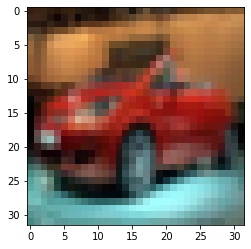

In [9]:
plt.imshow(img_ex)

In [10]:
print("Label: "+str(label_ex)+"\nCategory: "+str(category_ex))

Label: 1
Category: b'automobile'


#### Preparing X and y

In [11]:
X_raw, Y_raw = batch_to_xy(batch1)

In [12]:
X_raw.shape

(10000, 3072)

In [13]:
Y_raw.shape

(10000,)

In [14]:
#Apply PCA to reduce the number of features
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=99, random_state=RANDOM_STATE_SEED)
tf_X = pca.fit_transform(X=X_raw)

In [15]:
tf_X.shape

(10000, 99)

In [16]:
X_raw = tf_X

In [17]:
# now we remove two classes from the dataset
unknown1 = 8
unknown2 = 9
u1_idx = Y_raw == unknown1
u2_idx = Y_raw == unknown2
u_idx = u1_idx + u2_idx
X_raw_closed = np.delete(X_raw, u_idx, axis=0)
y_raw_closed = np.delete(Y_raw, u_idx, axis=0)

In [18]:
Y_raw_new = Y_raw
# -1 is the unknown class label
Y_raw_new[u_idx] = -1;

In [19]:
# Isolate our examples for our labeled dataset.
n_labeled = X_raw_closed.shape[0]   #Number of samples
training_indices = np.random.randint(low=0, high=n_labeled, size=int(n_labeled*0.75))

In [20]:
X_train = X_raw_closed[training_indices]
y_train = y_raw_closed[training_indices]
X_train.shape

(5995, 99)

In [21]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw_closed, training_indices, axis=0)
y_pool = np.delete(y_raw_closed, training_indices, axis=0)

In [22]:
X_pool.shape

(3771, 99)

### Initializing the learner

In [23]:
knn = KNeighborsClassifierOpenSet(n_neighbors_os=3, weights_os='distance')

In [24]:
# Pre-set our batch sampling to retrieve BATCH_SIZE samples at a time.
BATCH_SIZE = 10
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

In [25]:
learner = ActiveLearner(
    estimator=knn,
    X_training=X_train,
    y_training=y_train,
    query_strategy=preset_batch
)

In [26]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw_closed)
is_correct = (predictions == y_raw_closed)
print(is_correct)

[ True  True  True ...  True  True False]


In [27]:
# closed set score
unqueried_score = learner.score(X_raw_closed, y_raw_closed)
print(unqueried_score)

0.6861396047035276


In [28]:
# setting the open set classifier threshold
learner.estimator.set_threshold(unqueried_score)

In [29]:
# open set score
open_score = learner.estimator.score_open_set(X_raw, Y_raw_new)
print(open_score)

0.5485


In [30]:
N_QUERIES = 20

In [32]:
performance_history = [unqueried_score]
open_performance_history = [open_score]
print(performance_history)
print(open_performance_history)

[0.6861396047035276]
[0.5485]


### Active learning loop

In [33]:
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw_closed, y_raw_closed)
    learner.estimator.set_threshold(model_accuracy)
    model_open_accuracy = learner.estimator.score_open_set(X_raw, Y_raw_new)
    print('Closed set accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    print('Open set accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_open_accuracy))
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    open_performance_history.append(model_open_accuracy)

Closed set accuracy after query 1: 0.6870
Open set accuracy after query 1: 0.5492
Closed set accuracy after query 2: 0.6883
Open set accuracy after query 2: 0.5502
Closed set accuracy after query 3: 0.6891
Open set accuracy after query 3: 0.5509
Closed set accuracy after query 4: 0.6900
Open set accuracy after query 4: 0.5516
Closed set accuracy after query 5: 0.6909
Open set accuracy after query 5: 0.5523
Closed set accuracy after query 6: 0.6918
Open set accuracy after query 6: 0.5530
Closed set accuracy after query 7: 0.6930
Open set accuracy after query 7: 0.5540
Closed set accuracy after query 8: 0.6941
Open set accuracy after query 8: 0.5549
Closed set accuracy after query 9: 0.6951
Open set accuracy after query 9: 0.5557
Closed set accuracy after query 10: 0.6963
Open set accuracy after query 10: 0.5566
Closed set accuracy after query 11: 0.6974
Open set accuracy after query 11: 0.5575
Closed set accuracy after query 12: 0.6983
Open set accuracy after query 12: 0.5582
Closed set

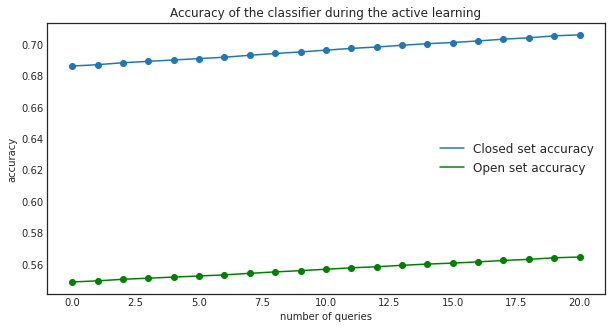

In [34]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(N_QUERIES+1), performance_history)
    plt.scatter(range(N_QUERIES+1), performance_history)
    plt.plot(range(N_QUERIES+1), open_performance_history, 'g')
    plt.scatter(range(N_QUERIES+1), open_performance_history, c='g')
    plt.legend(['Closed set accuracy','Open set accuracy'], fontsize = 'large')
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

### Unknown class detection

In [43]:
X_unknown = X_raw[u_idx]
y_unknown = Y_raw_new[u_idx]

In [44]:
X_unknown.shape[0]

2006

In [45]:
unknown_classes_prediction = learner.estimator.predict_open(X_unknown)

In [46]:
is_correct = unknown_classes_prediction == y_unknown

In [49]:
# number of correct unknown classes detections 
correct = np.count_nonzero(is_correct)
print(correct)

1390


In [48]:
# accuracy
correct/X_unknown.shape[0]

0.6929212362911267